# 战前准备
- 引入绘图、随机数、系统、时间模块
- 设置绘图参数，使中文、负号正常显示
- 设置基础参数如地图大小、胜率表等

In [92]:
import matplotlib.pyplot as plt
import random, sys, time, os

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

Times = 1000000
Map_Size = 27
Win_Rate = {"卡卡罗": 0, "今汐": 0, "长离": 0, "守岸人": 0, "椿": 0, "珂莱塔": 0, "洛可可": 0, "菲比": 0, "布兰特": 0, "坎特蕾拉": 0,
            "赞妮": 0, "卡提希娅": 0}
Cubes = {"A": ["卡卡罗", "今汐", "长离", "守岸人", "椿", "珂莱塔"], "B": ["洛可可", "菲比", "布兰特", "坎特蕾拉", "赞妮", "卡提希娅"]}

# 对地图的操作
- 地图重置
- 地图初始化

In [93]:
def Map_Reset() -> list[list]: # 创建空地图
    return [[] for i in range(Map_Size)]

def Map_Init(mode: int, cubes: list[str]) -> list[list]: # 不同模式的初始化
    # 创建空地图
    map = Map_Reset()
    if mode == 0: # 上半场
        map[3] = [cube for cube in cubes]
        random.shuffle(map[3])
    elif mode == 1: # 下半场、灵活变通
        map[3], map[3 - len(cubes) // 2] = [cubes[0]], [cubes[-1]]
        for i in range(2, 3 - len(cubes) // 2, -1): map[i] = cubes[(6 - i * 2): (4 - i * 2): -1]
    return map

# 地图上的查询
- 查询团子的位置
- 查询团子的排名
- 查询当前排行榜

In [94]:
def Get_Map_Pos(cube: str, map: map) -> int: # 寻找团子在地图上的位置
    for i in range(len(map)):
        if cube in map[i]: return i

def Get_Rank(cube: str, map: map) -> int: # 查询团子的当前排名
    rank = 1
    for i in range(len(map) - 1, -1, -1): # 从后往前找
        for j in range(len(map[i]) - 1, -1, -1): # 在上面的排名靠前
            if map[i][j] == cube: return rank
            rank += 1

def Get_Ranks(map: map) -> list[str]: # 查询当前排行榜
    ranks = []
    for i in range(len(map) - 1, -1, -1): ranks += map[i][::-1]
    return ranks

# 拆解单轮行动
- 决定行动顺序
- 决定行动步数
- 指定团子移动
- 行动后技能判定与发动

In [95]:
def Decide_Turn(cubes: list[str], map: list[list], skill: dict, mode: int) -> tuple[list[str], dict]: # 决定行动序列
    if mode == 0: cube_turn = map[3][::-1] # 上半场首轮
    elif mode == 1: # 其他轮次
        cube_turn = [cube for cube in cubes]
        random.shuffle(cube_turn)
    if "长离" in cube_turn and skill["长离"]: # 发动长离技能
        cube_turn.remove("长离")
        cube_turn.append("长离")
        skill["长离"] = False
    return (cube_turn, skill)

def Decide_Step(cube: str, map: list[list], skill: dict, cube_turn: list[str]) -> tuple[int, dict]: # 决定行动步数 
    # 基础步数
    if cube == "守岸人": step = random.randint(2, 3)
    elif cube == "赞妮": step = random.randint(1, 2) * 2 - 1
    else: step = random.randint(1, 3)
    # 技能步数
    if cube == "卡卡罗":
        if Get_Rank(cube = cube, map = map) == len(cube_turn): step += 2
    elif cube == "椿":
        if random.randint(1, 2) == 1:
            step += len(map[Get_Map_Pos(cube = cube, map = map)]) - 1
            skill[cube] = True
    elif cube == "珂莱塔":
        if random.randint(1, 25) <= 7: step *= 2
    elif cube == "洛可可":
        if cube_turn[-1] == cube: step += 2
    elif cube == "菲比":
        if random.randint(1, 2) == 1: step += 1
    elif cube == "布兰特":
        if cube_turn[0] == cube: step += 2
    elif cube == "赞妮":
        if skill[cube]:
            step += 2
            skill[cube] = False
        if len(map[Get_Map_Pos(cube = cube, map = map)]) > 1:
            if random.randint(1, 5) <= 2: skill[cube] = True # 赞妮技能判定
    elif cube == "卡提希娅":
        if skill[cube]:
            if random.randint(1, 5) <= 3: step += 2
    return (step, skill)

def Move(cube: str, map: list[list], skill: dict, step: int) -> tuple[list[list], dict]: # 指定团子移动
    # 计算起点、终点
    src = Get_Map_Pos(cube = cube, map = map)
    dst = src + step
    if dst >= len(map): dst = len(map) - 1
    # 具体团子移动
    stack = []
    if cube == "椿" and skill[cube]: # 椿技能发动
        map[src].remove(cube)
        map[dst].append(cube)
        skill[cube] = False
    elif cube == "坎特蕾拉" and not skill[cube]: # 坎特蕾拉技能未发动
        while map[src][-1] != cube: stack.append(map[src].pop())
        stack.append(map[src].pop())
        for i in range(src + 1, dst + 1):
            if map[i] != []: # 技能触发
                skill[cube] = True
                break
        if skill[cube]: # 技能发动
            stack += map[i][::-1]
            map[i] = []
        map[dst] += stack[::-1]
    else: # 其他情况
        while map[src][-1] != cube: stack.append(map[src].pop())
        stack.append(map[src].pop())
        map[dst] += stack[::-1]
    return (map, skill)

def Skill(cube: str, cubes: list[str], map: list[list], skill: dict, mode: int) -> tuple[list[list], dict]: # 行动后技能判定与发动
    if "今汐" in cubes:
        map_pos_jx = Get_Map_Pos(cube = "今汐", map = map)
        if mode == 1 or cubes.index(cube) > cubes.index("今汐"): # 上半场首轮今汐行动后才触发
            if map[map_pos_jx].index("今汐") < len(map[map_pos_jx]) - 1:
                if random.randint(1, 5) <= 1:
                    map[map_pos_jx].remove("今汐")
                    map[map_pos_jx].append("今汐")
    elif "长离" in cubes:
        if map[Get_Map_Pos(cube = "长离", map = map)].index("长离") > 0:
            if random.randint(1, 20) <= 13: skill["长离"] = True
    elif "卡提希娅" in cubes and cube == "卡提希娅":
        if Get_Rank(cube = "卡提希娅", map = map) == len(cubes): skill["卡提希娅"] = True
    return (map, skill)

# 将比赛看作整体
- 一轮行动
- 半场比赛
- 一场比赛
- 小团快跑

In [96]:
def Game_Cycle(cubes: list[str], map: list[list], skill: dict, mode: int) -> tuple: # 进行一轮行动
    # 决定行动顺序、发动长离技能
    cube_turn, skill = Decide_Turn(cubes = cubes, map = map, skill = skill, mode = mode)
    for cube in cube_turn: # 轮流行动
        # 决定步数、移动
        step, skill = Decide_Step(cube = cube, map = map, skill = skill, cube_turn = cube_turn)
        map, skill = Move(cube = cube, map = map, skill = skill, step = step)
        # 胜利判定、技能判定与发动
        if map[-1] != []: return (map, skill, True)
        map, skill = Skill(cube = cube, cubes = cubes, map = map, skill = skill, mode = mode)
    return (map, skill, False)

def Game_Half(cubes: list[str], map: list[list], mode: int) -> list[str]: # 半场比赛
    # 重置技能
    skill = {}
    for cube in cubes: skill[cube] = False
    # 一轮一轮地比赛
    map, skill, res = Game_Cycle(cubes = cubes, map = map, skill = skill, mode = mode)
    while not res: map, skill, res = Game_Cycle(cubes = cubes, map = map, skill = skill, mode = 1)
    # 提取排名
    ranks = Get_Ranks(map = map)
    return ranks

def Game_Whole(cubes: list[str]) -> list[str]: # 进行上下半场比赛
    # 上半场
    map = Map_Init(mode = 0, cubes = cubes)
    ranks_above = Game_Half(cubes = cubes, map = map, mode = 0)
    # 下半场
    map = Map_Init(mode = 1, cubes = ranks_above)
    ranks = Game_Half(cubes = cubes, map = map, mode = 1)
    return ranks

def Running_Cubes(cubes: dict) -> str: # 进行完整的小团快跑
    # A组、B组小组赛
    ranks_a_game1 = Game_Whole(cubes = cubes["A"])[0: -2]
    ranks_b_game1 = Game_Whole(cubes = cubes["B"])[0: -2]
    # A组、B组淘汰赛
    ranks_a_game2 = Game_Whole(cubes = ranks_a_game1)[0: -2]
    ranks_b_game2 = Game_Whole(cubes = ranks_b_game1)[0: -2]
    # 总决赛
    ranks_final_game = Game_Whole(cubes = ranks_a_game2 + ranks_b_game2)
    return ranks_final_game[0]

# 比赛之外
- 展示结果
- 生成进度条

In [97]:
def Show_Win_Rate(win_rate: dict) -> None: # 用饼状图展示胜率
    # 降序排序、团子表、胜率表
    win_rate = sorted(win_rate.items(), key = lambda k: k[1], reverse = True)
    cubes = [item[0] for item in win_rate]
    rates = [item[1] for item in win_rate]
    # 绘制饼状图、展示
    plt.pie(rates, labels = cubes, autopct = "%1.1f%%")
    plt.show()

def Stat_Bar(stat: int) -> str: # 依据进度生成对应的进度条
    stat = stat * 100 // Times + 1
    if stat <= 9:    stat_bar = "[" + "=" * (stat // 2) + " " * (25 - stat // 2) + str(stat) + "%" + " " * 23 + "]"      # 0~9
    elif stat <= 47: stat_bar = "[" + "=" * (stat // 2) + " " * (24 - stat // 2) + str(stat) + "%" + " " * 23 + "]"      # 10~47
    elif stat <= 55: stat_bar = "[" + "=" * 24 + str(stat) + "%" + " " * 23 + "]"                                        # 48~55
    elif stat <= 99: stat_bar = "[" + "=" * 24 + str(stat) + "%" + "=" * (stat // 2 - 27) + " " * (50 - stat // 2) + "]" # 56~99
    else:            stat_bar = "[" + "=" * 23 + str(stat) + "%" + "=" * 23 + "]"                                        # 100
    return stat_bar

# 主函数、程序运行

模拟进度: [=======================100%=======================]

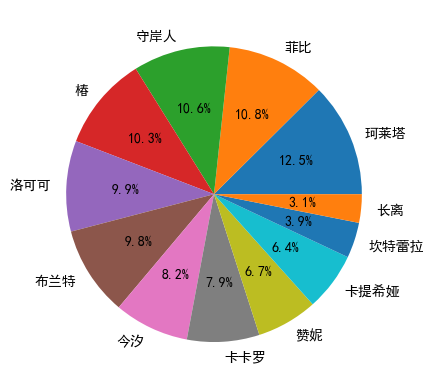

In [98]:
def main():
    time_src = time.time()
    for i in range(Times): # 百万场小团快跑
        win = Running_Cubes(cubes = Cubes)
        Win_Rate[win] += 1
        # 依据时间刷新进度条
        time_dst = time.time()
        if time_dst - time_src >= 1:
            time_src = time_dst
            stat_bar = Stat_Bar(stat = i)
            os.system("clear")
            sys.stdout.write("\r模拟进度: ")
            sys.stdout.write(stat_bar)
    Show_Win_Rate(win_rate = Win_Rate)

if __name__ == "__main__": main()